# Immersed Cylinder benchmarking

This notebook will contain all the required scripts and commands to produce the
benchmarking for the immersed cylinder case. This requires the following steps:

We expect the simulation for the `cylinder_benchmark` example have been
completed and that the resulting data is available in the `cylinder_benchmark`
subdirectory of the results folder.

The benchmarking consists of a few different sub-benchmarks:

1. Inflection point detection.
2. Backdraft region detection.
3. Leakage detection.

In [1]:
# Setup the paths for the project
import sys
import os

sys.path.append('modules')
path = os.path.realpath(
    os.path.join(os.getcwd(), '../results/cylinder_benchmark'))

# Check that the folder exists
if not os.path.exists(path):
    print("The path to the results folder does not exist.")
    print("Please run the benchmark first.")
    print("\tcd NEKO_TOP_ROOT")
    print("\t./setup.sh")
    print("\t./run.sh cylinder_benchmark")
    exit(404)


## Inflection point detection

The inflection points we are looking for are the points where the fluid around
the cylinder changes sign. These will move as vortices are formed and shed. We
are interested in detecting these points and tracking them over time.

### Post processing the data

The first step is to post-process the data to extract the inflection points.
This is done by probing the velocity field in a circle around the cylinder and
detecting the points where the velocity changes sign. Each point will be
converted to just an angle and a time, as the radius of the circle is fixed.


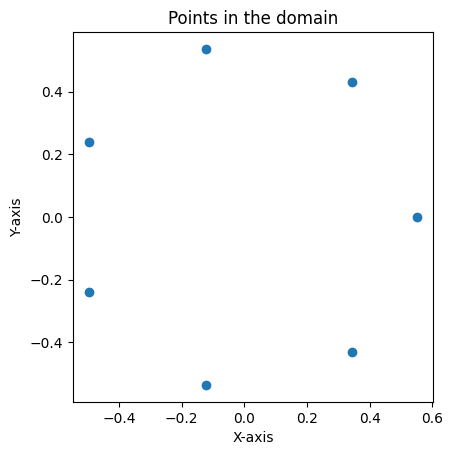

In [2]:
# Read in the file and setup the data
from nekotop import read_probes

file_name = 'meshed_inflection.csv'

# Check that the file exists
if not os.path.exists(file_name):
    file_name = os.path.join(path, file_name)
    if not os.path.exists(file_name):
        print("The file does not exist.")
        exit(404)

# If the points variable is not initialized, read in the data
if not 'is_initialized' in locals():
    points, fields, times, field_names = read_probes(file_name)
    N_points = points.shape[0]
    N_fields = fields.shape[1]
    N_times = int(times.shape[0] / N_points)
    is_initialized = True

# Plot the points in a 2D plot. (Z-axis should be constant)
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(points[:, 0], points[:, 1])
ax.set_aspect('equal')
plt.title("Points in the domain")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


The angle of the inflection point is:  0.26031823459029857
Angle and flow:  -2.6927937030769655 0.6855630779399835
Angle and flow:  2.6927937030769655 -0.5646976492555557


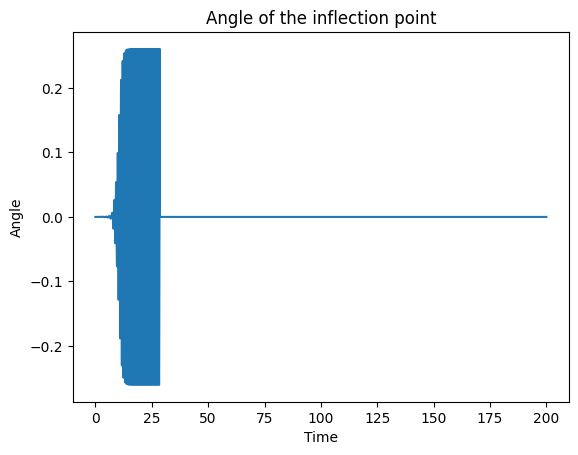

In [7]:
import numpy as np


def compute_angle(center, point, axis=np.array([1.0, 0.0, 0.0])):
    """
    Compute the angle between the center and the point
    """

    # Compute the angle
    angle = np.arctan2(point[1] - center[1], point[0] - center[0])

    return angle


# Plot the points in a 2D plot. (Z-axis should be constant)
import matplotlib.pyplot as plt

center = np.array([0.0, 0.0, 0.0])

angle_inflection = np.zeros(len(times))

for ti in range(N_times):
    t = times[ti]

    angles = np.zeros(points.shape[0])
    flow = np.zeros(points.shape[0])
    for i in range(points.shape[0]):
        angles[i] = compute_angle(center, points[i, :])

        if i + ti * N_points >= fields.shape[0]:
            print("Index out of bounds")
            print("Index: ", i + ti * N_points)
            print("Fields shape: ", fields.shape)
            print("I: ", i)
            print("Ti: ", ti)
            print("N_points: ", N_points)
            exit(404)

        flow[i] = -fields[i + ti * N_points, 0] * np.sin(
            angles[i]) + fields[i + ti * N_points, 1] * np.cos(angles[i])

    # Sort the angle list and the flow list
    idx = np.argsort(angles)

    i_p = int(1 / 4 * len(idx))
    i_n = i_p - 1

    while (flow[idx[i_p]] <= 0 or flow[idx[i_n]] >= 0
           or flow[idx[i_p]] < flow[idx[i_n]]):
        s = -1

        i_p = (i_p + s) % len(idx)
        i_n = (i_n + s) % len(idx)

    # Compute the angle of the inflection point
    angle_p = angles[idx[i_p]]
    angle_n = angles[idx[i_n]]
    flow_p = flow[idx[i_p]]
    flow_n = flow[idx[i_n]]

    angle_inflection[ti] = angle_n + (angle_p - angle_n) * flow_n / (flow_n -
                                                                     flow_p)

print("The angle of the inflection point is: ", angle_inflection[ti])
print("Angle and flow: ", angle_p, flow_p)
print("Angle and flow: ", angle_n, flow_n)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, angle_inflection)
plt.title("Angle of the inflection point")
plt.xlabel("Time")
plt.ylabel("Angle")
plt.show()
